# Notes

In this example, we aim to delve into the features learned through our pretraining process, with a focus on identifying the most significant types of features. Our exploration will first cover cell-level features, followed by an analysis of geneset-level features.

In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
# load the pretrained model as a feature extractor
pretrainer = loadconceptor('../checkpoint/latest/pretrainer.pt')

In [3]:
genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

1019894

In [4]:
data_path = '/home/was966/Research/mims-conceptor/paper/00_data'

In [5]:
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

# df_label = df_label[df_label.sub_cohort_used_flag]
# df_tpm = df_tpm.loc[df_label.index]

df_tpm.shape, df_label.shape

((1140, 15672), (1140, 112))

In [6]:
df_label.cohort = df_label.cancer_type + '_' +df_label.cohort
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)

In [7]:
dfgeneset, dfcelltype = pretrainer.extract(dfcx,  batch_size= 32)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# dfgeneset = pd.DataFrame(scaler.fit_transform(dfgeneset), index =dfgeneset.index, columns = dfgeneset.columns)
# dfcelltype = pd.DataFrame(scaler.fit_transform(dfcelltype), index =dfcelltype.index, columns = dfcelltype.columns)

/home/was966/Research/mims-conceptor/conceptor/encoder/layer/performer.py:78: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  q, r = torch.qr(unstructured_block.cpu(), some = True)
100%|##########| 36/36 [00:07<00:00,  4.79it/s]


In [8]:
label = df_label['response_label']
cohort = df_label['cohort']
cancer = df_label['cancer_type']

In [9]:
import scipy.stats as stats
# dfp

Text(233.25, 0.5, 'Cohort')

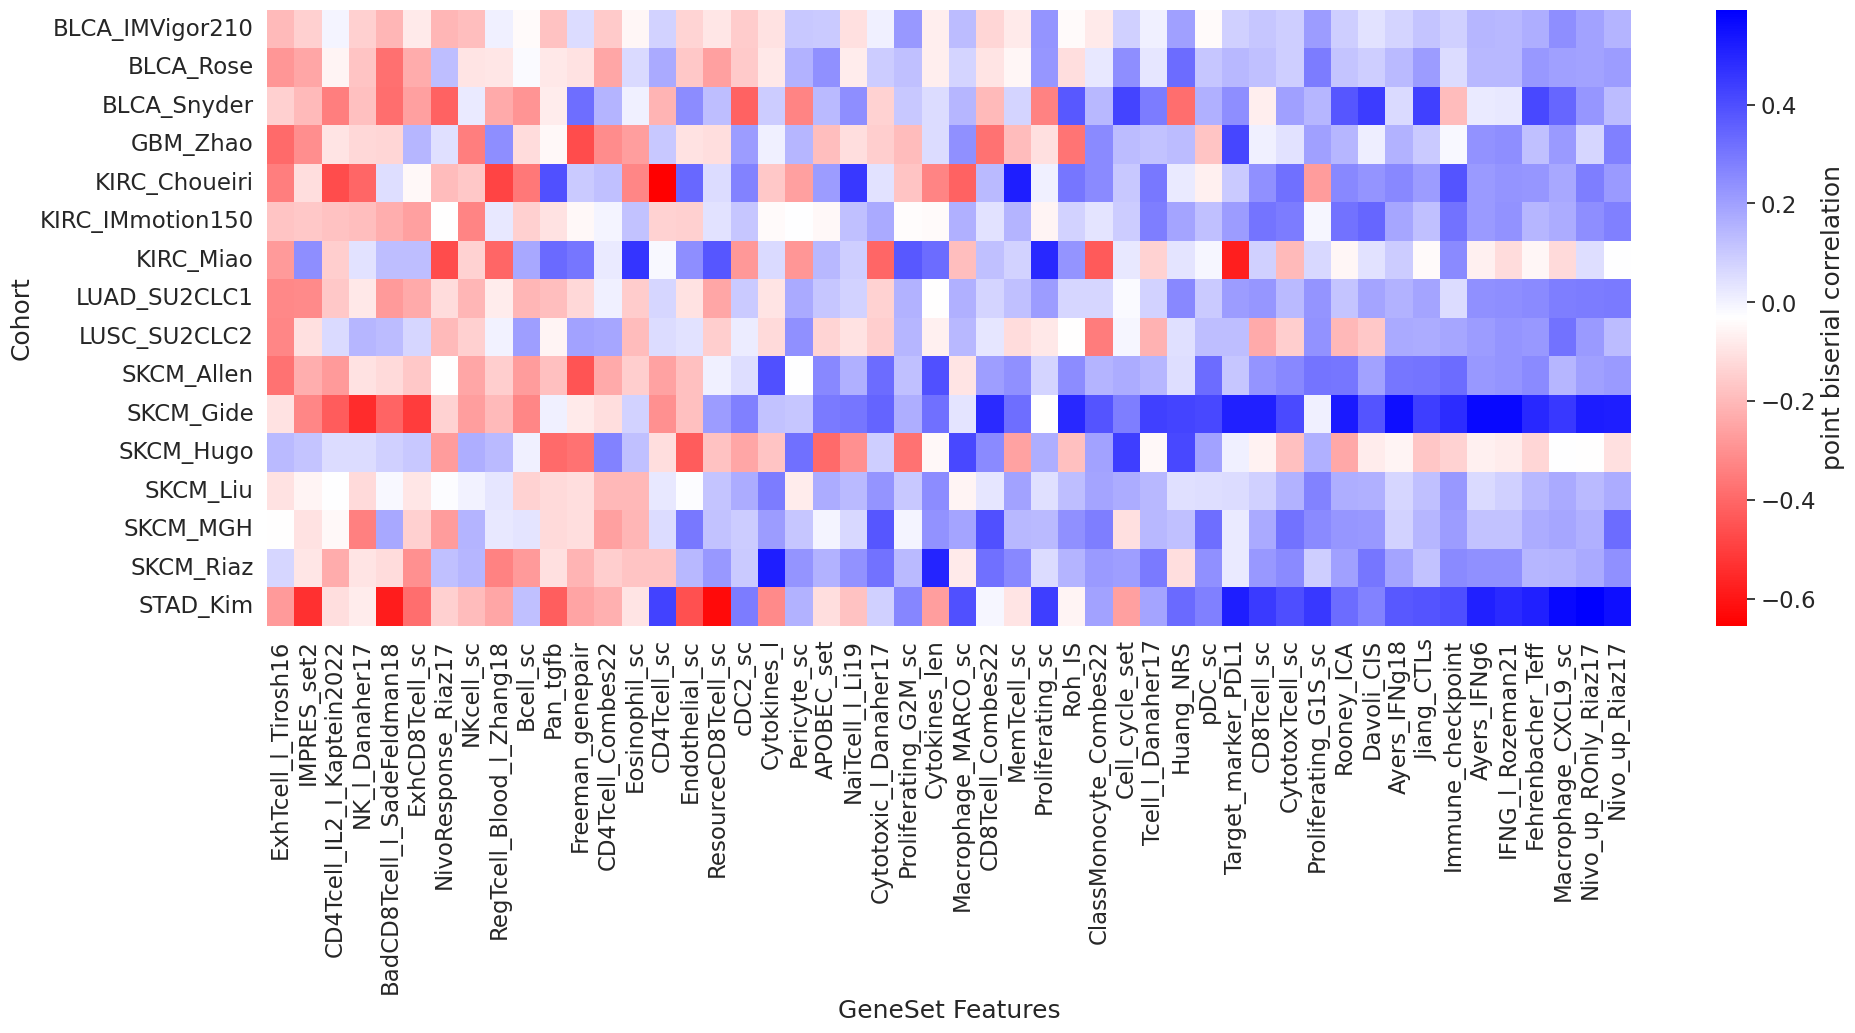

In [10]:
dfp = dfgeneset.join(label).join(cohort)
res= []
for f in dfgeneset.columns:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 
                                                                                        'NR':0}), 
                                                                  x[f])[0])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
selected_geneset = pcc.abs().mean().sort_values().tail(50).index
pcc = pcc[selected_geneset]


pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[cohort.unique()]


fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(pcc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'})

# groups = df_label[['cancer_type', 'cohort']].drop_duplicates().groupby('cancer_type').cohort.apply(lambda x:x.tolist()).to_dict()
# annotate_yranges(groups, ax =ax)
  
ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

Text(233.25, 0.5, 'Cohort')

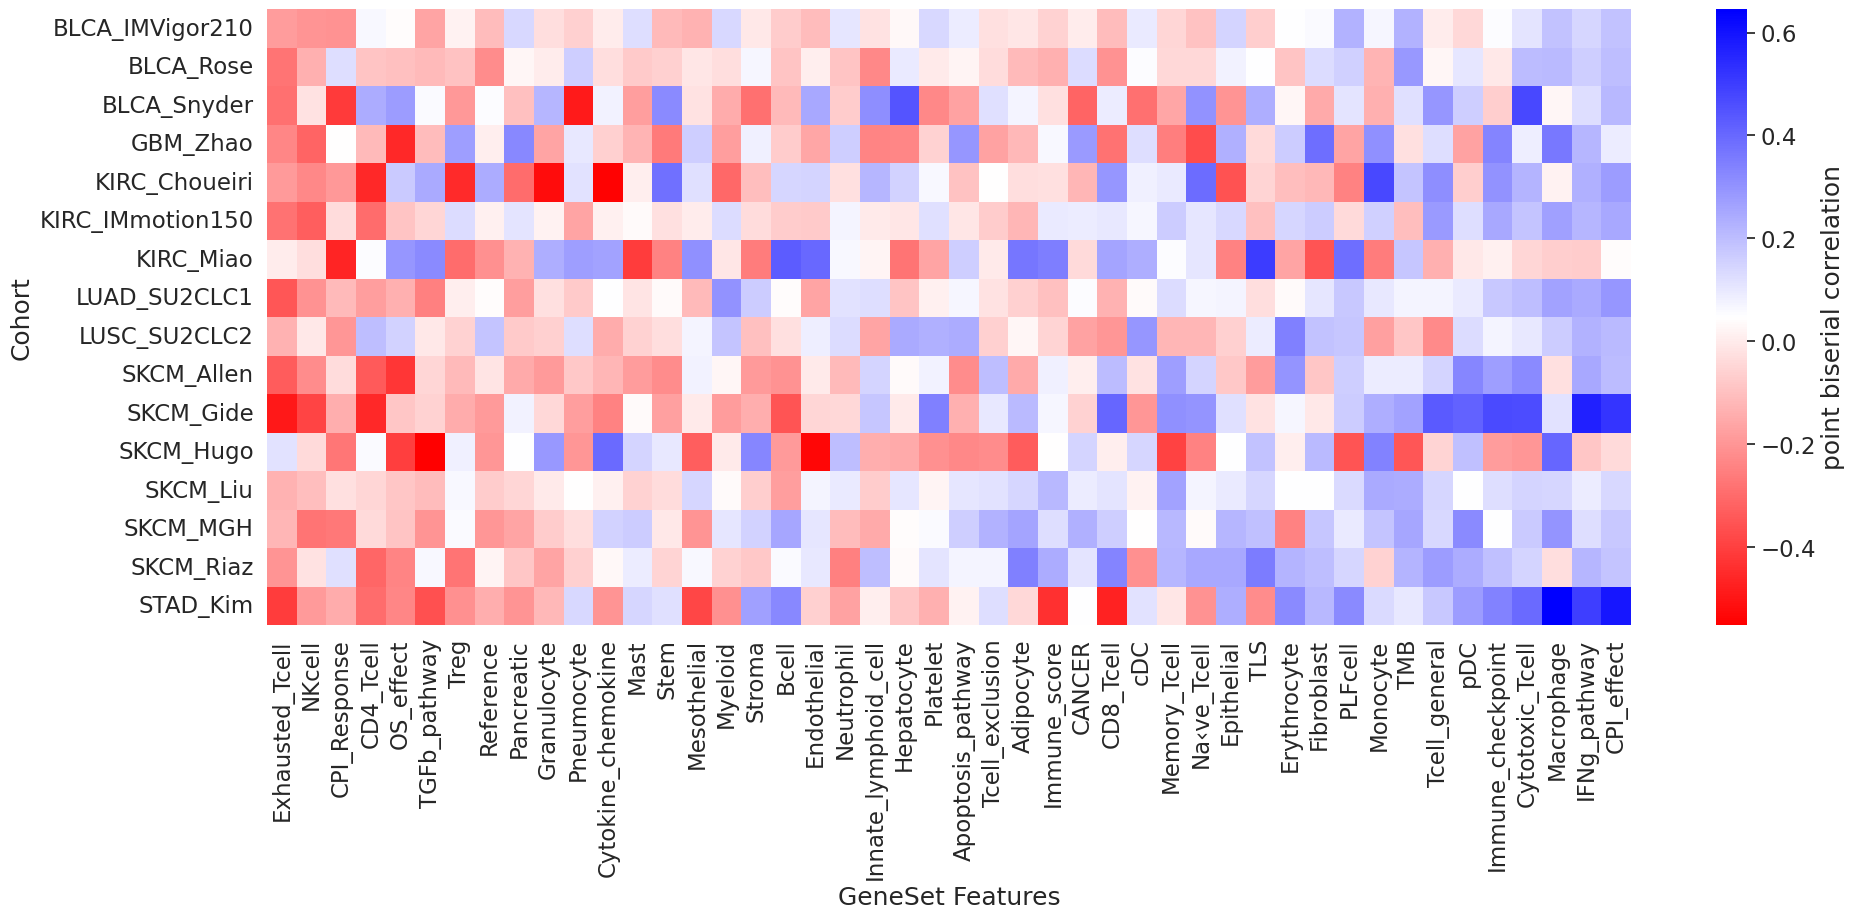

In [11]:
dfp = dfcelltype.join(label).join(cohort)
res= []
for f in dfcelltype.columns:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 
                                                                                        'NR':0}), 
                                                                  x[f])[0])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
selected_geneset = pcc.abs().mean().sort_values().tail(50).index
pcc = pcc[selected_geneset]

pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[cohort.unique()]

fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(pcc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'},) # vmin=-0.4, vmax=0.4

# groups = df_label[['cancer_type', 'cohort']].drop_duplicates().groupby('cancer_type').cohort.apply(lambda x:x.tolist()).to_dict()
# annotate_yranges(groups, ax =ax)

ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

(1.0, 0.4980392156862745, 0.054901960784313725)

/tmp/ipykernel_10012/4186096563.py:37: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = data, x = x, y = y2,
/tmp/ipykernel_10012/4186096563.py:40: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = data, x = x, y = y1,


desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:7.744e-09 U_stat=5.890e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.584e-07 U_stat=5.184e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:4.412e-17 U_stat=3.962e+03
desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:1.249e-11 U_stat=1.562e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:7.721e-11 U_stat=1.417e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:3.425e-18 U_stat=2.520e+02


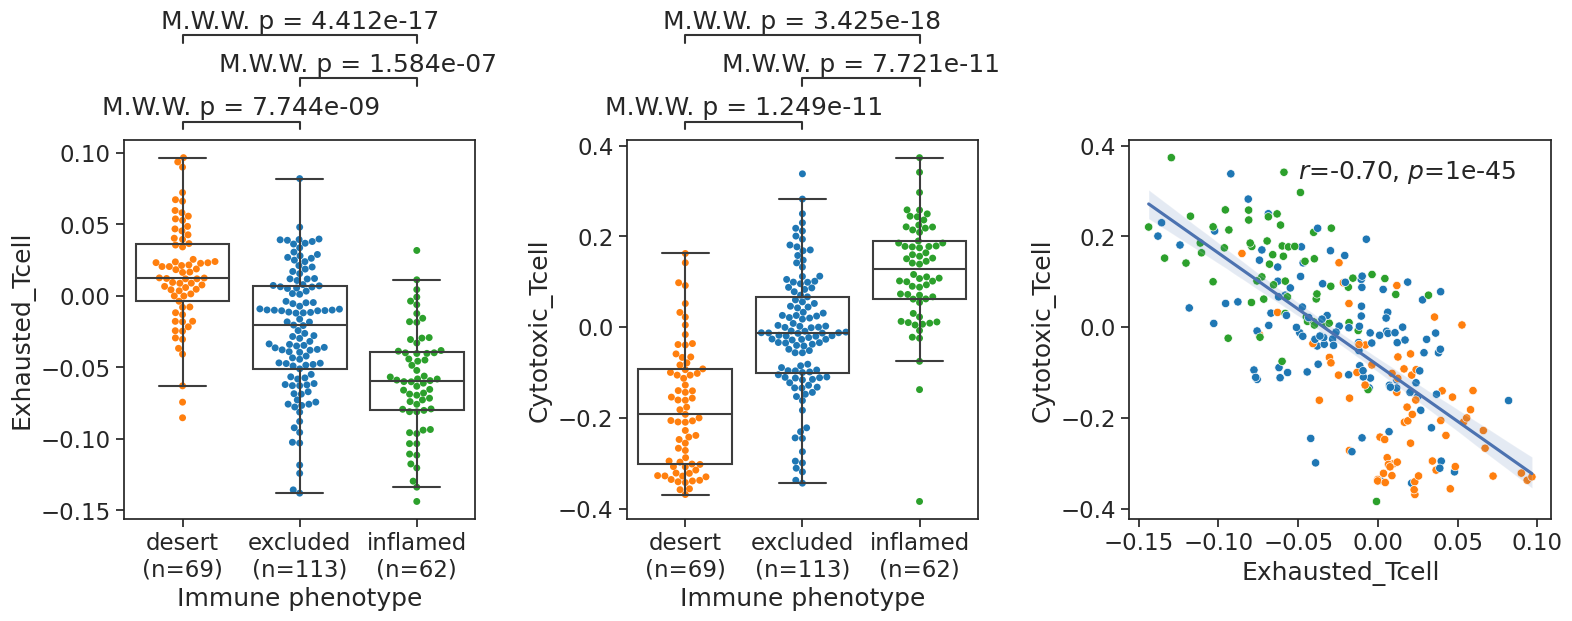

In [85]:
IMVigor210 = df_label[df_label.cohort == 'BLCA_IMVigor210']

x = 'Immune phenotype'
y1 = 'Exhausted_Tcell'
y2 = 'Cytotoxic_Tcell'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='full', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='full',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    
fig.tight_layout()

In [37]:
mycohort = 'BLCA_IMVigor210(Atezo)'
data2 = df_label[df_label.cohort == mycohort]
data2 = data2[['TMB (FMOne mutation burden per MB)']].join(dfcelltype[['TMB']]).dropna()
data2['log2TMB'] = np.log2(data2['TMB (FMOne mutation burden per MB)']+1)
#sns.jointplot(data=data2, x="log2TMB", y="TMB", kind="reg")
data2['cohort'] = mycohort

mycohort = 'BLCA_Rose(Pembro)'
data3 = df_label[df_label.cohort.isin([mycohort])]
data3 = data3[['TMB']].rename(columns={'TMB':'TMB_true'}).join(dfcelltype[['TMB']]).dropna()
data3['log2TMB'] = np.log2( data3['TMB_true']+1)
data3['cohort'] = mycohort

mycohort = 'SKCM_Liu(Pembro)'
data4 = df_label[df_label.cohort == mycohort]
data4 = data4[['log2_tmb.wang']].join(dfcelltype[['TMB']]).dropna()
data4['log2TMB'] = data4['log2_tmb.wang']
data4['cohort'] = mycohort


mycohort = 'SKCM_Riaz(Nivo)'
data5 = df_label[df_label.cohort == mycohort]
data5 = data5[['log2_tmb.wang']].join(dfcelltype[['TMB']]).dropna()
data5['log2TMB'] = data5['log2_tmb.wang']
data5['cohort'] = mycohort


data = data2._append(data3)._append(data4)._append(data5)
#fig, ax = plt.subplots(figsize=(8, 8))

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

fig = sns.regplot(data=data2, x="log2TMB", y="TMB", ax=ax)
# fig.tight_layout()

In [ ]:
data = dfcelltype[['TMB']].join(cohort)
data = data.join(dfcelltype['Reference'])
data = data.set_index('cohort')

fig, ax = plt.subplots(figsize=(15,4))

g = data.plot(ax=ax)

#g = sns.lineplot(data=df, x="index", y=y, )
df = data.reset_index()

cohort_color = sns.color_palette('tab20', len(df.cohort.unique()))
cohort_color.as_hex()
overlay = dict(zip(df.cohort.unique(), cohort_color.as_hex()))

for cohort_name in df.cohort.unique():
    tmp = df[df.cohort == cohort_name]
    v = overlay.get(cohort_name)
    g.axvspan(min(tmp.index), max(tmp.index)+1, color=v, alpha=0.3)
    g.text(((min(tmp.index)+max(tmp.index)+1) / 2)-1, 1.05,
           '{}'.format(tmp.cohort.unique()[0]), rotation = 30, 
           ha = 'left', fontsize=12)



ax.set_xlabel('Patients')
ax.set_xlim(-1, len(df)+1)
ax.set_ylabel('PT-readout')

ax.set_xticks([])
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.0),
          fancybox=True, shadow=True, ncol=1)
#ax.axhspan(ymin = -1, ymax=-0.4, xmin=0, xmax=0.1, alpha=.5)

In [ ]:
x = 'IMPRES_set1'
y = 'Plasma_sc'
hue = 'response_label'
dff = dfgeneset[[x,y]]

dfp2 = dff.join(label).join(cohort)

num_figs = len(dfp2.cohort.unique())


fig, axes = plt.subplots(nrows=4, ncols = 3, figsize=(10, 12),
                         sharex=True,
                         sharey=True,)

from itertools import chain
axes = list(chain(*axes))
gps = dfp2.groupby('cohort')

for ax, g in zip(axes, gps):
    group, data = g
    sns.scatterplot(data = data,  x = x, y=y, hue=hue, ax=ax, legend=False)
    ax.set_title(group)

fig.tight_layout()

In [ ]:
dff = dfcelltype[['Cytotoxic_Tcell', 'NKcell', ]].rename(columns={'Cytotoxic_Tcell':'Cyt_Tcell'})
dfp2 = dff.join(label).join(cohort)

fig, axes = plt.subplots(nrows=4, ncols = 4, figsize=(12, 12),
                         sharex=True,
                         sharey=True,)

from itertools import chain
axes = list(chain(*axes))
gps = dfp2.groupby('cohort')

for ax, g in zip(axes, gps):
    group, data = g
    pd.plotting.parallel_coordinates(data, 'response_label', ax=ax,
                                     cols = dff.columns, sort_labels =True,
                                     color=( 'g', 'r'))
    ax.set_title(group)

#fig.tight_layout()

In [ ]:
# Adipocyte, Fibroblast, Melanoma, Malignant, Pancreaticxxxxx
# pcc['Epithelial']

In [ ]:
# res = []
# for f in celltype_feature_names:
#     p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[1])
#     p = p.to_frame(f)
#     res.append(p)

# pcc = pd.concat(res, axis=1)
# pcc = pcc[pcc.mean().sort_values().index]
# pcc = pcc.loc[pcc.mean(axis=1).sort_values().index]
# # pcc = 1.5**pcc
# fig, ax = plt.subplots(figsize = (22,4))
# sns.heatmap(pcc, cmap = 'rainbow', ax=ax, cbar_kws={'label': 'pvalue'})

# ax.set_xlabel('Broad Cell type Features')
# ax.set_ylabel('Cohort')

In [ ]:
# from statannot import add_stat_annotation
# for y in celltype_feature_names:
#     x = 'cohort'
#     hue = 'response_label'
#     data = dfp

#     fig, ax = plt.subplots(figsize = (10,4))
#     sns.violinplot(data = data, x=x, y=y, hue=hue, ax=ax)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
    
#     # add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
#     #                     box_pairs=[("R", "NR")],
#     #                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

In [ ]:
# w = cellpathwayprojector.cellpathway_aggregator.aggregator.attention_weights['cellpathway_30']
# idx = genesetprojector.GENESET.iloc[cellpathwayprojector.CELLPATHWAY.loc['Tcell']].index.to_list()
# Tcell_weights = pd.DataFrame(w.cpu().detach().numpy(),columns = ['attention weights'], index=idx)
# fig, ax = plt.subplots(figsize = (20,4))

# Tcell_weights.sort_values('attention weights').plot(kind='bar',ax=ax)
# ax.set_ylabel('Weights')
# ax.set_xlabel('Gene sets')
# plt.xticks(rotation=75, ha='right')